## Workflows
- Workflows are systems where LLMs and tools are orchestrated through predefined code paths. Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

## Prompt Chaining
Prompt chaining is a technique where a complex task is broken down into a series of smaller, sequential steps. The output from one language model (LLM) call is used as the input for the next, creating a "chain" of operations that guide the process toward a final, more accurate result.

Think of it like an assembly line for information. Instead of one worker trying to build an entire car from scratch (a single, complex prompt), each worker performs one specific task—add the wheels, install the engine, paint the body—before passing it to the next station.
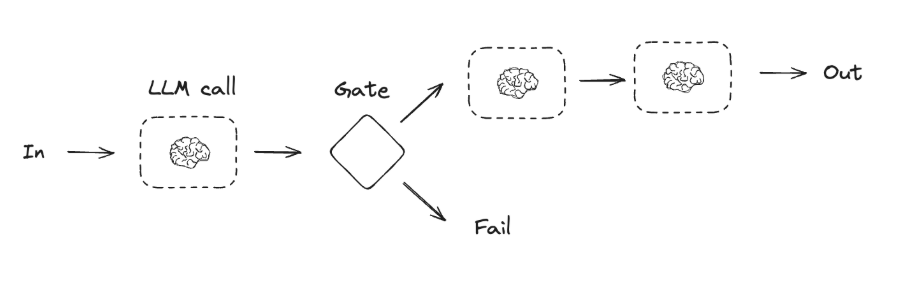

## When to use this workflow: 
This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.



In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [ ]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_tavily
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen/qwen3-32b")

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [ ]:
# nodes
def generate_joke(state:State):
    """ First LLm Call to generate a joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke":msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [ ]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect the nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)


In [ ]:
# Compile
chain = workflow.compile()

In [ ]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
state = chain.invoke({"topic": "AI"})

In [ ]:
print(state["joke"])

## Parallelization
Parallelization is a workflow where multiple LLM calls work on a task simultaneously, either by breaking the task into independent parts or by running the same task multiple times to generate diverse outputs. The results are then combined programmatically to produce a final answer.

The core idea is to leverage parallel processing to either speed up a task or improve its quality and reliability.

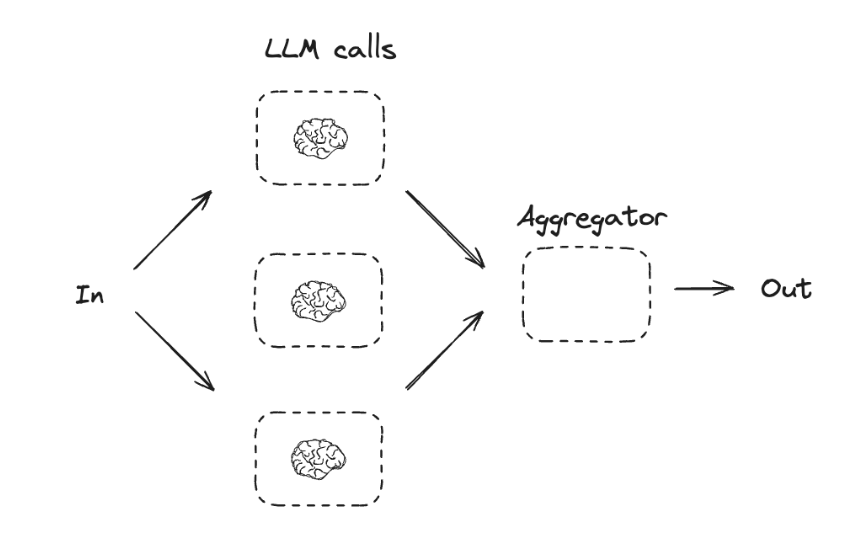
## When to Use Parallelization
This workflow is powerful in specific scenarios:

1. To Increase Speed: When a task can be cleanly divided into parts that don't depend on each other (like summarizing different chapters of a book), sectioning can dramatically reduce the total time required.

2. To Improve Quality & Confidence: When a task is subjective or complex, voting provides a way to cross-reference multiple outputs. This helps mitigate the risk of a single LLM producing a flawed or "hallucinated" answer and allows you to choose the most robust response.

3. For Complex Tasks: For problems with many different facets (e.g., "Analyze the pros and cons of a business strategy"), it's often better to have one LLM focus only on the "pros" and another focus only on the "cons." This focused attention for each aspect generally yields higher-quality, more detailed results than asking a single LLM to handle everything at once.

In [ ]:
# Graph state
class State(TypedDict):
    topic:str
    characters:str
    settings:str
    premises:str
    story_intro:str

In [ ]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [ ]:
def generate_characters(state:State):
    """ Generate character Descriptions"""
    msg = llm.invoke(f" Create two Character names and brief traits for a story about {state["topic"]}")
    return {"characters":msg.content}
def generate_setting(state:State):
    """ Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story {state["topic"]}")
    return {"settings":msg.content}
def generate_premise(state:State):
    """ Generate a Story Premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises":msg.content}

def combine_elements(state:State):
    """Combine Characters setting and premise into an intro"""
    msg = llm.invoke(f"Write a short story introduction using these elements: \n"
                     f"Characters:{state['characters']} \n "
                     f"Setting : {state['settings']} \n"
                     f"Premise : {state['premises']}"
                     )
    return {"story_intro":msg.content}


In [ ]:
graph = StateGraph(State)

graph.add_node("character",generate_characters)
graph.add_node("setting",generate_setting)
graph.add_node("premise",generate_premise)
graph.add_node ("combine",combine_elements)



In [ ]:
graph.add_edge(START,"character")
graph.add_edge(START,"setting")
graph.add_edge(START,"premise")

graph.add_edge("character","combine")
graph.add_edge("setting","combine")
graph.add_edge("premise","combine")
graph.add_edge("combine",END)

compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [ ]:
state = {"topic":"Time Travel"}
result = compiled_graph.invoke(state)


In [ ]:
print(result)

In [ ]:
import pprint
pprint.pprint(result, indent=4, width=100)



## Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

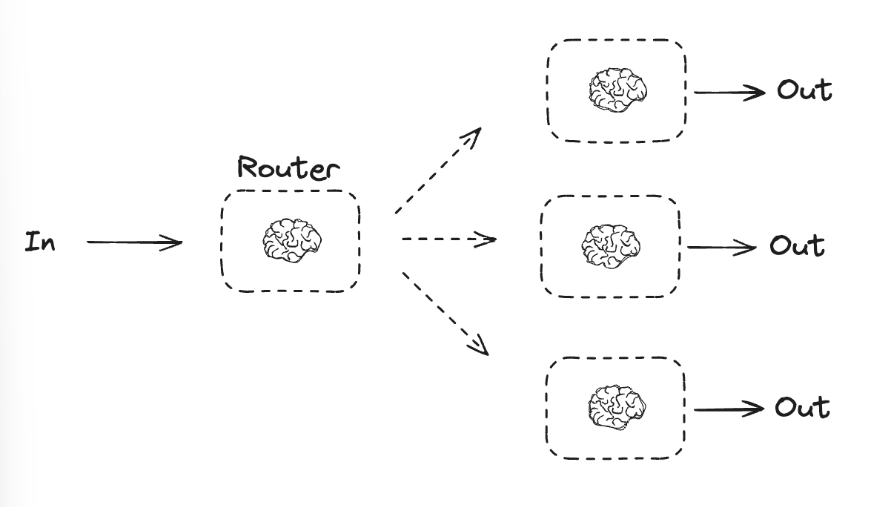
## When to use this workflow: 
Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.



In [ ]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [ ]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


In [ ]:
# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [ ]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str


In [ ]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"



In [ ]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)


In [ ]:
# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [ ]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state)

## Orchestrator-Worker
In an orchestrator-worker configuration, the orchestrator:
- Breaks down tasks into subtasks
- Delegates subtasks to workers
- Synthesizes worker outputs into a final result

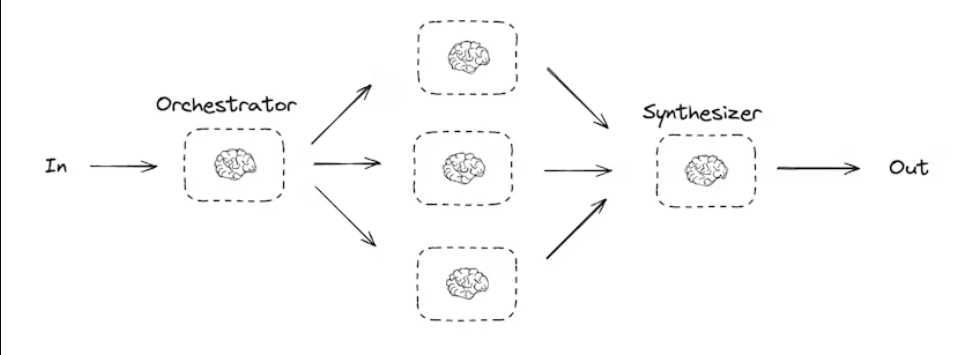

Orchestrator-worker workflows provide more flexibility and are often used when subtasks cannot be predefined the way they can with parallelization. This is common with workflows that write code or need to update content across multiple files. For example, a workflow that needs to update installation instructions for multiple Python libraries across an unknown number of documents might use this pattern.

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


## Creating workers in LangGraph

Orchestrator-worker workflows are common and LangGraph has built-in support for them. The Send API lets you dynamically create worker nodes and send them specific inputs. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. The example below iterates over a list of sections and uses the Send API to send a section to each worker.

In [4]:
from langgraph.types import Send
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


In [6]:
from langgraph.graph import StateGraph, START, END
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

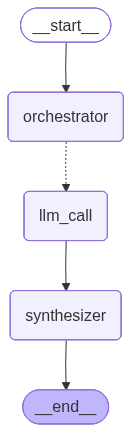

In [7]:
from IPython.display import Image, display


# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [8]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})


In [9]:
from IPython.display import Markdown
Markdown(state["final_report"])

### Introduction and Description: Overview of LLM Scaling Laws and Their Importance in AI Research
#### Background
Large Language Models (LLMs) have revolutionized the field of Artificial Intelligence (AI) by achieving state-of-the-art results in various natural language processing tasks. The development of LLMs is guided by scaling laws, which describe how the performance of these models improves with increases in model size, dataset size, and computational power. Understanding these scaling laws is crucial for optimizing the training of LLMs and improving their performance.

#### Importance of Scaling Laws
Scaling laws are essential in AI research because they provide a framework for predicting the performance of LLMs based on their size and training data. This knowledge enables researchers to make informed decisions about the design and training of these models, optimizing the use of computational resources and improving the efficiency of the training process. Furthermore, scaling laws help to identify the limitations of current models and guide the development of new architectures and training methods.

#### Current State of Research
Recent studies have investigated the scaling laws of LLMs, revealing that their performance improves logarithmically with the size of the model and the dataset. However, these studies also suggest that there are diminishing returns to scaling, and that other factors such as model architecture and training objectives play a significant role in determining the performance of LLMs. Ongoing research is focused on refining our understanding of these scaling laws and exploring new ways to improve the performance of LLMs.

#### Implications and Future Directions
The study of scaling laws has significant implications for the development of more powerful and efficient LLMs. By understanding how these models scale, researchers can design more effective training methods, optimize the use of computational resources, and improve the performance of LLMs on a wide range of tasks. As AI research continues to advance, the importance of scaling laws will only continue to grow, driving the development of more sophisticated models and training methods that can harness the power of large-scale computing and big data.

---

### Background and description: History and development of LLM scaling laws
#### Introduction to Scaling Laws
The concept of scaling laws in the context of Large Language Models (LLMs) refers to the empirical observations and mathematical formulations that describe how the performance of these models improves as their size, typically measured by the number of parameters, increases. The history and development of these laws are intricately tied to the advancement of deep learning technologies and the availability of large datasets.

#### Early Observations
Early work in deep learning hinted at the existence of such scaling laws, where larger models tended to perform better on a variety of tasks. However, it wasn't until the development of transformer-based architectures, such as BERT and its successors, that these observations became more systematic. Researchers began to notice that as the size of the model increased, its performance on natural language processing tasks improved in a somewhat predictable manner.

#### Formulation of Scaling Laws
The explicit formulation of scaling laws for LLMs is a more recent development. Researchers have identified several key factors that influence the scaling of model performance, including the number of parameters, the size of the training dataset, and the computational budget. These factors are often related through power-law relationships, suggesting that doubling the size of the model or the dataset can lead to predictable improvements in performance.

#### Empirical Evidence
Empirical studies have provided substantial evidence supporting the existence of these scaling laws. For instance, the performance of models on benchmark tasks such as language translation, question answering, and text generation has been shown to improve consistently as the model size increases. Additionally, the relationship between model size and performance has been found to be remarkably consistent across different architectures and tasks, suggesting a deeper, more fundamental principle at play.

#### Implications and Future Directions
The understanding and application of scaling laws have significant implications for the development of LLMs. By predicting how model performance will improve with size, researchers can better allocate resources, design more efficient training protocols, and set realistic expectations for model capabilities. Furthermore, the existence of these laws challenges the field to explore the limits of model scaling, both in terms of the technical feasibility of training ever-larger models and the theoretical limits of what can be achieved through scaling alone. As such, the study of scaling laws remains an active and exciting area of research, with potential to drive further breakthroughs in natural language processing and artificial intelligence.

---

### Theory and description: Theoretical foundations of LLM scaling laws and their mathematical formulations
Theoretical foundations of Large Language Model (LLM) scaling laws are rooted in the concept of scaling laws in machine learning, which describe how model performance improves as the size of the model and the amount of training data increase. 
#### Key Components
* **Model Size**: The number of parameters in the model, which affects its capacity to learn and represent complex patterns in the data.
* **Training Data Size**: The amount of data used to train the model, which influences the model's ability to generalize and learn from the data.
* **Compute Budget**: The amount of computational resources available for training the model, which impacts the model's training time and convergence.
#### Mathematical Formulations
The scaling laws for LLMs can be mathematically formulated as follows:
* **Power Law Scaling**: The model's performance improves according to a power law as the model size and training data size increase: $P \propto (N \cdot D)^{\alpha}$, where $P$ is the model's performance, $N$ is the model size, $D$ is the training data size, and $\alpha$ is the scaling exponent.
* **Logarithmic Scaling**: The model's performance improves logarithmically with the model size and training data size: $P \propto \log(N \cdot D)$.
These mathematical formulations provide a framework for understanding how LLMs scale and how their performance can be improved by increasing the model size, training data size, and compute budget.

---

### Empirical Evidence
#### Experimental Results
Experimental results have consistently shown that large language models (LLMs) exhibit scaling laws, where the performance of the model improves as the size of the model and the amount of training data increase. For example, a study on the scaling laws of LLMs found that the performance of the model on a variety of natural language processing tasks improved significantly as the size of the model increased from 100 million to 10 billion parameters.
#### Data Analysis
Data analysis has also provided insights into the scaling laws of LLMs. One key finding is that the performance of LLMs on a given task is closely tied to the amount of training data available. As the amount of training data increases, the performance of the model improves, but at a decreasing rate. This suggests that there are diminishing returns to increasing the size of the training dataset, and that other factors such as model architecture and optimization algorithms may become more important as the size of the training dataset increases.
#### Key Findings
Some key findings from the empirical evidence on LLM scaling laws include:
* **Parameter count**: Increasing the parameter count of an LLM leads to significant improvements in performance, but with diminishing returns.
* **Training data size**: Increasing the size of the training dataset leads to improvements in performance, but with diminishing returns.
* **Model architecture**: The choice of model architecture can have a significant impact on the performance of an LLM, with some architectures being more effective than others at leveraging large amounts of training data.
* **Optimization algorithms**: The choice of optimization algorithm can also have a significant impact on the performance of an LLM, with some algorithms being more effective than others at optimizing large models.

---

### Applications and Uses of LLM Scaling Laws
LLM scaling laws have numerous practical implications and uses in real-world scenarios, including:
* **Improved Model Efficiency**: By understanding how model performance scales with size, developers can create more efficient models that achieve the same performance with fewer parameters, reducing computational costs and environmental impact.
* **Personalized Education**: LLMs can be used to generate personalized educational content, such as tailored lesson plans and adaptive assessments, to improve student outcomes and increase access to quality education.
* **Content Generation**: LLMs can be used to generate high-quality content, such as articles, stories, and dialogue, for various industries, including entertainment, marketing, and media.
* **Language Translation**: LLMs can be used to improve language translation systems, enabling more accurate and nuanced communication across languages and cultures.
* **Conversational AI**: LLMs can be used to power conversational AI systems, such as chatbots and virtual assistants, to provide more human-like and effective interactions with users.
* **Text Summarization**: LLMs can be used to summarize long documents and articles, extracting key points and insights to help users quickly understand complex information.
* **Sentiment Analysis**: LLMs can be used to analyze text data to determine sentiment and emotional tone, providing valuable insights for businesses, marketers, and researchers.
* **Data Augmentation**: LLMs can be used to generate synthetic data, such as text, images, and audio, to augment existing datasets and improve model performance.

---

### Conclusion
The study of LLM scaling laws has yielded significant insights into the relationships between model size, dataset size, and computational resources. **Key findings** include:
* The existence of power-law relationships between model performance and scale
* The importance of considering dataset size and quality in scaling laws
* The potential for scaling laws to inform the design of more efficient and effective LLMs
Future research directions may include:
* **Investigating the applicability of scaling laws to other AI models and domains**
* **Developing more nuanced and detailed models of LLM scaling behavior**
* **Exploring the potential for scaling laws to inform the development of more specialized and efficient LLMs**

## Evaluator-optimizer
In evaluator-optimizer workflows, one LLM call creates a response and the other evaluates that response. If the evaluator or a human-in-the-loop determines the response needs refinement, feedback is provided and the response is recreated. This loop continues until an acceptable response is generated.
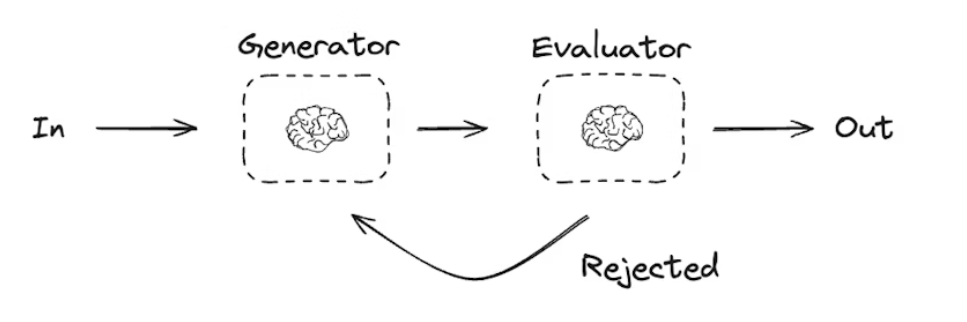

Evaluator-optimizer workflows are commonly used when there’s particular success criteria for a task, but iteration is required to meet that criteria. For example, there’s not always a perfect match when translating text between two languages. It might take a few iterations to generate a translation with the same meaning across the two languages.

In [10]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [12]:
# Schema for structured output to use in evaluation
from typing_extensions import Literal

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

In [13]:
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [14]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

In [15]:
 #Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)


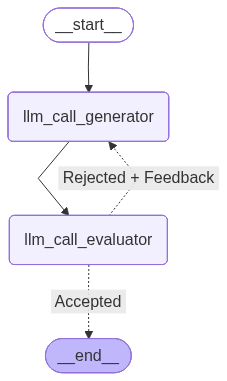

In [16]:
# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))


In [ ]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])


Why did the cat join a band?

Because it wanted to be the purr-cussionist!


: 